In [36]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.sparse as sps
import pickle
import time 
import argparse
import multiprocessing as mp
import os
import sys

sys.path.append('./source')
# import utils
import kernel
import models

# Settings

In [10]:
idx_ver = 1
use_maturity_mask= True 
flg_mp =False 
num_t_each_trunk =1000 

freq = 'daily'
R = 10 
l_fixed = 10.0 
alpha = 0.05 
delta = 0.0 

# Load data and parameters

In [11]:
lst_R_fit=None

### where to save output
dir_out = './KR_ret_example/'
if not os.path.isdir(dir_out):
    os.makedirs(dir_out)
print('*'*3 +'Save results to: '+ '*'*3+'\n'+dir_out)

### get path and load lookup table
dir_B = './B_and_C/B_max_ttm_10yr/'
print('Reading data from {}'.format(dir_B))
df_t_lookup_freq = pd.read_pickle(dir_B + 'df_t_lookup_{}.pkl'.format(freq))
df_t_lookup_daily = pd.read_pickle(dir_B + 'df_t_lookup_{}.pkl'.format('daily'))

B_mat = np.load(dir_B + 'B_mat.npy')
Bc_shift_mat = np.load(dir_B + 'Bc_shift_mat.npy')
with open(dir_B + "dict_par.pkl", "rb") as handle:
    dict_par = pickle.load(handle)
nmax, Nmax, prefix_C, dir_npz = [dict_par[key] for key in ['nmax','Nmax','prefix_C','npz_dir']]


# load daily risk-free rate
df_rf = pd.read_pickle('./data_supplement/df_riskfree_daily_all.pkl').KR_LS

# load mask
dir_mask = './mask/'
mat_mask_maturity = np.load(dir_mask + 'mat_filter_maturity_90days.npy')
mat_nt = np.load(dir_mask + 'mat_nt.npy')
mat_ytm = np.load(dir_mask + 'mat_ytm.npy')

# load daily discount curve
df_g_daily = pd.read_pickle('./data_supplement/df_kr_g.pkl')

***Save results to: ***
./KR_ret_example/
Reading data from ./B_and_C/B_max_ttm_10yr/


# Generate the kernel matrix for fixed $\alpha$ and $\delta$

In [12]:
K = kernel.generate_kernel_matrix(alpha, delta, Nmax, Nmax)

# SVD
U,D_diag,Vh = np.linalg.svd(K)
V = Vh.T
D = np.diag(D_diag) # D is a matrix
DV_inv = V@np.diag(1/np.sqrt(D_diag))
assert np.isclose(U[:,:10],V[:,:10]).all()

dict_svd = {'V':V,
            'D_diag':D_diag,
            'DV_inv':DV_inv}


# Fit KR model for each date

In [26]:
example_dates_ls = ['1986-06-30', '2013-12-31']
lst_t_freq = [df_t_lookup_freq.loc[i].t for i in example_dates_ls]

In [31]:
for t_freq in lst_t_freq:
    
    t = df_t_lookup_freq.iloc[t_freq].t
    today = df_t_lookup_freq.index[t_freq]
    today_str = today.strftime('%Y-%m-%d')

    # return over x days. find the subsequent date
    if t+1==len(df_t_lookup_daily) or np.count_nonzero(B_mat[:,t])==0: 
        # can't find the subsequent date or no eligible securities today
        print('skipping t:{}, t_freq:{}, date:{}'.format(t,t_freq,today_str))
        continue

    date_s = (df_t_lookup_daily.index[t+1]-df_t_lookup_daily.index[t]).days
    B = B_mat[:,t]
    nt = int(mat_nt[t])

    # filter step
    if use_maturity_mask:
        mask_keep = mat_mask_maturity[t,:nt]
        mask_keep = np.logical_and(mask_keep, mat_ytm[t,:nt] < 0.25) 
    else:
        mask_keep = np.full(nt, True)

    csr_mat_name = dir_npz+prefix_C+'C_'+str(t)+'.npz'
    csr_mat = sps.load_npz(csr_mat_name)

    # remove empty rows from B and C
    # apply filter
    B = B[:nt][mask_keep]
    Bc_shift = Bc_shift_mat[:nt,t][mask_keep]
    C = csr_mat.toarray()[:nt,1:][mask_keep]
    nt = len(B)

    print('t:{}, t_freq:{}, date:{}, nt: {}, date_s:{}'.format(t,t_freq,today_str, nt, date_s))

    # normalize prices to 1
    Bc_shift = (1/B)*Bc_shift
    C = (1/B)[:,np.newaxis]*C
    B = np.ones(nt)*1

    # get return of securities
    rf = (1+df_rf.loc[today_str])**date_s-1 # scalar
    ret = (Bc_shift-B)/B
    rx = ret-rf

    # get one-day excess return of zcb
    g = df_g_daily.iloc[t].values

    Z_bar = C[:,date_s-1:]@np.diag(g[date_s-1:Nmax]) # dim: (nt, Nmax-date_s+1)
    Z = Z_bar[:,1:] # dim: (nt, Nmax-date_s)

    dict_full = models.one_fit(Z = Z,
                l_unscaled = l_fixed,
                rx = rx, # (Bc_shift-B)/B - rf
                date_s = date_s, # number of day shifts
                K = K # 2D, specific to alpha
                )

    # factor model
    dict_fm = models.FM_ridge_solution(Z = Z,
                l_unscaled = l_fixed,
                rx = rx, # (Bc_shift-B)/B - rf
                date_s = date_s, # number of day shifts
                V = dict_svd['V'], # svd of K
                D_diag = dict_svd['D_diag'], # svd of K
                R = R, # max number of factors
                lst_R_fit = lst_R_fit # list of r used for fitting. will override R above
                )
    
    # compile output
    dict_out={
          'rx': rx, # rx of underlying securities
          'ret':ret, # ret of underlying securities
          'date_s':date_s, # date spacing
          'rf':rf, # compounded rf with date_s
          'dict_full':dict_full,
          'dict_fm':dict_fm
         }
    
    with open(dir_out+'dict_ret_curve_tfreq_{}_t_{}.pkl'.format(t_freq,t),'wb') as handle:
        pickle.dump(dict_out,handle,protocol=pickle.HIGHEST_PROTOCOL)  
    

t:6240, t_freq:6240, date:1986-06-30, nt: 140, date_s:1
t:13114, t_freq:13114, date:2013-12-31, nt: 239, date_s:2


# Plot fitted return curve

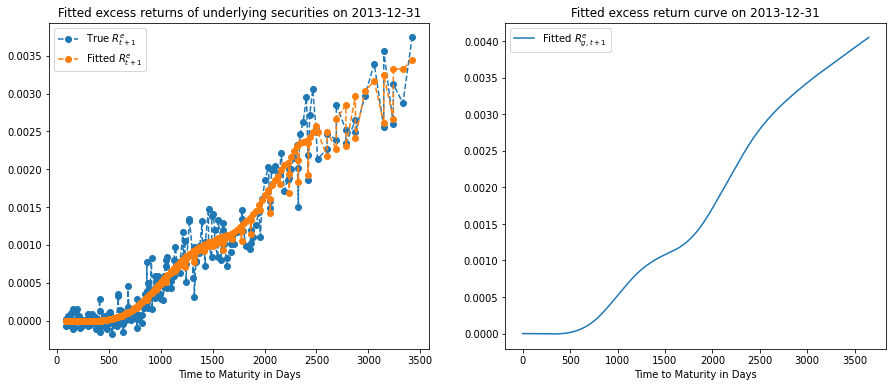

In [38]:
example_date = '2013-12-31'
t_freq = df_t_lookup_freq.loc[example_date].t

t=df_t_lookup_freq.iloc[t_freq].t
date=df_t_lookup_freq.index[t_freq]
date_s=(df_t_lookup_freq.index[t_freq+1]-df_t_lookup_freq.index[t_freq]).days


B=B_mat[:,t]
nt=int(mat_nt[t])

# filter step
mask_keep=mat_mask_maturity[t,:nt]
mask_keep=np.logical_and(mask_keep, mat_ytm[t,:nt] < 0.25) 


csr_mat_name=dir_npz+prefix_C+'C_'+str(t)+'.npz'
csr_mat=sps.load_npz(csr_mat_name)

# remove empty rows from B and C
# apply filter
B=B[:nt][mask_keep]
Bc_shift=Bc_shift_mat[:nt,t][mask_keep]
C=csr_mat.toarray()[:nt,1:][mask_keep]
nt=len(B)

# get ttm in day for further analysis
lst_ttm_inday=np.apply_along_axis(lambda row: len(row)-(row!=0)[::-1].argmax(),1,C)

with open(dir_out+'dict_ret_curve_tfreq_{}_t_{}.pkl'.format(t_freq,t),\
                  "rb") as handle:
    dict_t = pickle.load(handle) 
    
fig=plt.figure(figsize=(15,6))
ax_1,ax_2=fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

rx_g_full=dict_t['dict_full']['rx_g_full']
rx=dict_t['rx']
rx_full=dict_t['dict_full']['rx_full']

ax_1.plot(np.sort(lst_ttm_inday),rx[np.argsort(lst_ttm_inday)],'--o',label=r'True $R_{t+1}^e$')
ax_1.plot(np.sort(lst_ttm_inday),rx_full[np.argsort(lst_ttm_inday)],'--o',label=r'Fitted $R_{t+1}^e$')
ax_1.set_title('Fitted excess returns of underlying securities on {}'.format(example_date))

ax_2.plot(rx_g_full,label=r'Fitted $R_{g,t+1}^e$')
ax_2.set_title('Fitted excess return curve on {}'.format(example_date))

for ax in [ax_1,ax_2]:
    ax.set_xlabel('Time to Maturity in Days')
    ax.legend();